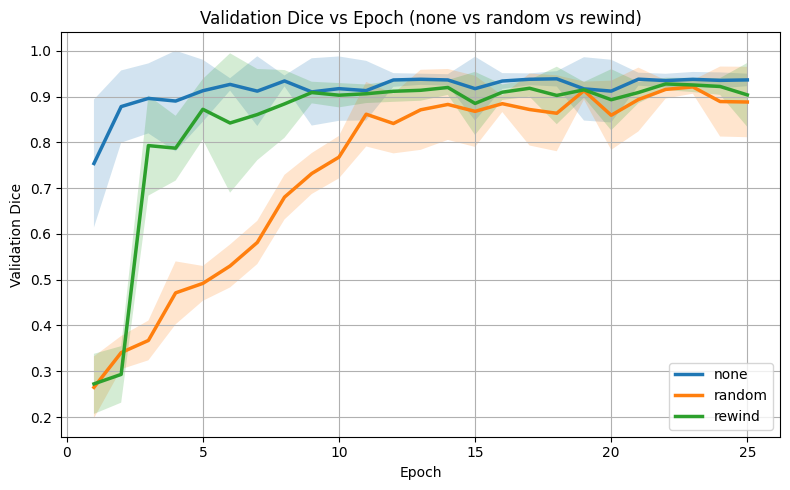

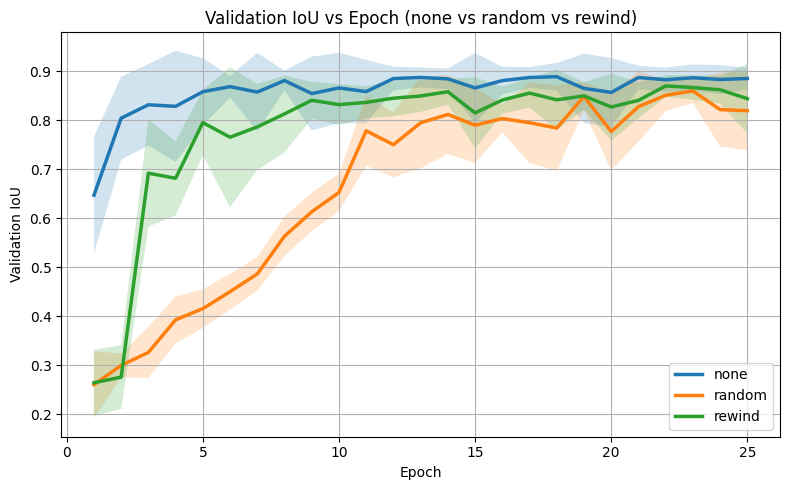

In [5]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

RESULTS_ROOT = "/mnt/hdd/ttoxopeus/basic_UNet/results"
MODEL_NAME = "UNet_ACDC"


def _read_json(path: str) -> dict:
    with open(path, "r") as f:
        return json.load(f)


def _infer_reinit_mode(run_name: str) -> str:
    name = run_name.lower()
    if name.endswith("_random"):
        return "random"
    if name.endswith("_rewind"):
        return "rewind"
    return "none"


def load_reinit_metrics_long_df(
    exp_name: str,
    run_names: list[str],
    model_name: str = MODEL_NAME,
    results_root: str = RESULTS_ROOT,
    metrics_relpath: str = os.path.join("retraining_pruned", "metrics_per_epoch.json"),
) -> pd.DataFrame:
    rows = []
    for run_name in run_names:
        metrics_path = os.path.join(
            results_root, model_name, exp_name, "pruned", run_name, metrics_relpath
        )
        if not os.path.isfile(metrics_path):
            raise FileNotFoundError(f"Missing: {metrics_path}")

        log = _read_json(metrics_path)
        if "epoch" not in log:
            raise ValueError(f"'epoch' missing in {metrics_path}")

        n = len(log["epoch"])
        mode = _infer_reinit_mode(run_name)

        for i in range(n):
            r = {
                "exp": exp_name,
                "run_name": run_name,
                "reinit_mode": mode,
                "epoch": log["epoch"][i],
            }
            for k, v in log.items():
                if isinstance(v, list) and len(v) == n:
                    r[k] = v[i]
            rows.append(r)

    df = pd.DataFrame(rows)
    df["epoch"] = pd.to_numeric(df["epoch"], errors="coerce")
    df = df.dropna(subset=["epoch"]).sort_values(["reinit_mode", "epoch"])
    return df


def plot_metric_with_std(
    df_long: pd.DataFrame,
    mean_col: str,
    std_col: str,
    *,
    max_epoch: int | None = None,
    title: str | None = None,
    ylabel: str | None = None,
):
    if df_long.empty:
        raise ValueError("Empty dataframe")

    for col in (mean_col, std_col, "epoch", "reinit_mode"):
        if col not in df_long.columns:
            raise ValueError(f"Column '{col}' not found. Available: {list(df_long.columns)}")

    d = df_long.copy()
    if max_epoch is not None:
        d = d[d["epoch"] <= max_epoch]

    plt.figure(figsize=(8, 5))

    for mode, g in d.groupby("reinit_mode"):
        g = g.sort_values("epoch")

        mean = g[mean_col].astype(float).to_numpy()
        std = g[std_col].astype(float).to_numpy()
        x = g["epoch"].astype(int).to_numpy()

        plt.plot(x, mean, linewidth=2.5, label=mode)
        plt.fill_between(x, mean - std, mean + std, alpha=0.2)

    plt.xlabel("Epoch")
    plt.ylabel(ylabel or mean_col)
    plt.title(title or f"{mean_col} vs epoch")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# --------------------------
# Your exp62 runs (exact)
# --------------------------
EXP = "exp62"
RUNS = [
    "l1_norm_0_0_0_99_99_99_99_99_0_0_0",
    "l1_norm_0_0_0_99_99_99_99_99_0_0_0_random",
    "l1_norm_0_0_0_99_99_99_99_99_0_0_0_rewind",
]

df_long = load_reinit_metrics_long_df(EXP, RUNS)

# Plot 1: Dice with std band
plot_metric_with_std(
    df_long,
    mean_col="val_dice_mean",
    std_col="val_dice_std",
    max_epoch=25,
    title=f"Validation Dice vs Epoch (none vs random vs rewind)",
    ylabel="Validation Dice",
)

# Plot 2: IoU with std band
plot_metric_with_std(
    df_long,
    mean_col="val_iou_mean",
    std_col="val_iou_std",
    max_epoch=25,
    title=f"Validation IoU vs Epoch (none vs random vs rewind)",
    ylabel="Validation IoU",
)
